<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>


## TFM
## 
* Burgos Angel 
* Cueva Castillo, Tania Piedad
  


## Descripción problema
Se tienen una data de los avistamientos del oso andino y otros dataset relacionados a la alimentación, ....,
Se plantea encontrar posibles relaciones entre los diferentes fuentes 

### Imports


In [84]:
%matplotlib inline
from IPython.display import HTML
import pandas as pd
import numpy as np
#from pandas import read_csv
from pandas.plotting import scatter_matrix

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
#import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree
from sklearn.svm import SVC


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## METRICAS
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


#from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.datasets import make_classification

import numpy as np
import seaborn as sns

from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from sklearn.model_selection import train_test_split


pd.__version__


'2.1.4'

###  Funciones a utlizar

In [85]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=test_porcentaje , random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=val_porcentaje, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [86]:
def seleccionar_atributos(df, columnas):
    ##columnas= ["BIOCLIMA", "TIPO VEGETACION","DEFICIT HIDRICO", "ALIMENTACION","PARROQUIA","OSOS","YEAR","MONTH","DAY","Latitud","Longitud"]
    df_seleccion = df[columnas]
    return (df_seleccion)

In [87]:
# Función que permite crear un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [88]:
# Transormador para variables categóricas usando hotEncoder
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [89]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

#### Random Forest

In [90]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [91]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

###  Lectura del conjunto de datos


In [92]:
# fichero con cabecera
encoding = 'utf8'
url1 ='https://raw.githubusercontent.com/Taniapcc/TFM/main/base_ok.csv'
##url1 = "base_ok.csv"
sep = ";"
df1 = pd.read_csv(url1, sep=sep,encoding = encoding)


###  Visualización

In [93]:
## identifica los atributos del dataset
df1.columns

Index(['PROVINCIA', 'CANTON', 'PARROQUIA', 'INCENDIOS', 'OSOS', 'ALIMENTACION',
       'Longitud', 'Latitud', 'Longitud-2', 'Latitud-2', 'TIPO VEGETACION',
       'BIOCLIMA', 'TIPO_ECOSI', 'FRAGILIDAD', 'AREA PROTEGIDA',
       'DEFICIT HIDRICO', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')

In [94]:
#identificar el tamaño del dataset
df1.shape

(17739, 19)

In [95]:
## visualizar el contenido del dataset
df1.tail(10)

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
17729,PICHINCHA,QUITO,SAN JOSE DE MINAS,NO,NO,Guzmania,0.16666,-78.58333,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,NaN,,NO DEFINIDA,70 - 80,1900,1,1
17730,MORONA SANTIAGO,SANTIAGO,SANTIAGO DE MENDEZ,NO,NO,Pitcairnia,-2.70000,-78.30000,0.0,0.0,TIERRA AGROPECUARIA,PLUVIAL,NaN,,NO DEFINIDA,000 - 000,1900,1,1
17731,NAPO,QUIJOS,SUMACO,NO,NO,Vriesea,-0.53333,-77.78333,0.0,0.0,BOSQUE,PLUVIAL,ECOSISTEMA TERRESTRE,BAJA,PARQUE NACIONAL,000 - 000,1900,1,1
17732,PICHINCHA,PUERTO QUITO,PUERTO QUITO,NO,NO,Guzmania,0.00000,-79.20000,0.0,0.0,TIERRA AGROPECUARIA,PLUVIAL,NaN,,NO DEFINIDA,70 - 80,1900,1,1
17733,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Tillandsia,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17734,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Pitcairnia,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17735,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Guzmania,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17736,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Catopsis,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17737,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Aechmea,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17738,AZUAY,CUENCA,VICTORIA DEL PORTETE (IRQUIS),NO,NO,Tillandsia,-3.10000,-79.08333,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,NaN,,NO DEFINIDA,450 - 475,1900,1,1


In [96]:
## identifica si existe valores nulos
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PROVINCIA        17739 non-null  object 
 1   CANTON           17739 non-null  object 
 2   PARROQUIA        17739 non-null  object 
 3   INCENDIOS        17739 non-null  object 
 4   OSOS             17739 non-null  object 
 5   ALIMENTACION     17739 non-null  object 
 6   Longitud         17739 non-null  float64
 7   Latitud          17739 non-null  float64
 8   Longitud-2       17739 non-null  float64
 9   Latitud-2        17739 non-null  float64
 10  TIPO VEGETACION  17739 non-null  object 
 11  BIOCLIMA         17739 non-null  object 
 12  TIPO_ECOSI       10496 non-null  object 
 13  FRAGILIDAD       17739 non-null  object 
 14  AREA PROTEGIDA   17739 non-null  object 
 15  DEFICIT HIDRICO  17739 non-null  object 
 16  YEAR             17739 non-null  int64  
 17  MONTH       

Análisis de atributos

In [97]:
df1['ALIMENTACION'].value_counts()

ALIMENTACION
Tillandsia       4546
Guzmania         4165
Pitcairnia       2306
Racinaea         1548
Aechmea          1419
Puya             1318
Vriesea           568
No Encontrada     437
Mezobromelia      229
Bromeliaceae      169
Werauhia          147
Greigia           138
Ronnbergia        137
Cipuropsis         87
Wallisia           85
Ananas             80
Catopsis           70
Neoregelia         56
Gregbrownia        52
Pepinia            32
Lemeltonia         30
Bromelia           26
Billbergia         25
Streptocalyx       24
Chevaliera         21
Barfussia          10
Renealmia           6
Chlorophytum        2
Josemania           2
Cryptanthus         1
Vriesia             1
 Guzmania           1
Hylaeaicum          1
Name: count, dtype: int64

In [98]:
df1['OSOS'].value_counts()

OSOS
NO    16733
SI     1006
Name: count, dtype: int64

In [99]:
df1['BIOCLIMA'].value_counts()

BIOCLIMA
PLUVIAL            12406
PLUVIESTACIONAL     3805
XÉRICO              1440
SIN INFORMACION       78
DESÉRTICO             10
Name: count, dtype: int64

In [100]:
df1['TIPO VEGETACION'].value_counts()

TIPO VEGETACION
BOSQUE                             8019
TIERRA AGROPECUARIA                5890
VEGETACION ARBUSTIVA Y HERBACEA    2066
ZONA ANTROPICA                     1262
CUERPO DE AGUA                      312
OTRAS TIERRAS                        99
SIN INFORMACION                      91
Name: count, dtype: int64

In [101]:
df1['FRAGILIDAD'].value_counts()

FRAGILIDAD
            7243
ALTA        4892
BAJA        1864
MUY ALTA    1805
MEDIA       1014
MUY BAJA     921
Name: count, dtype: int64

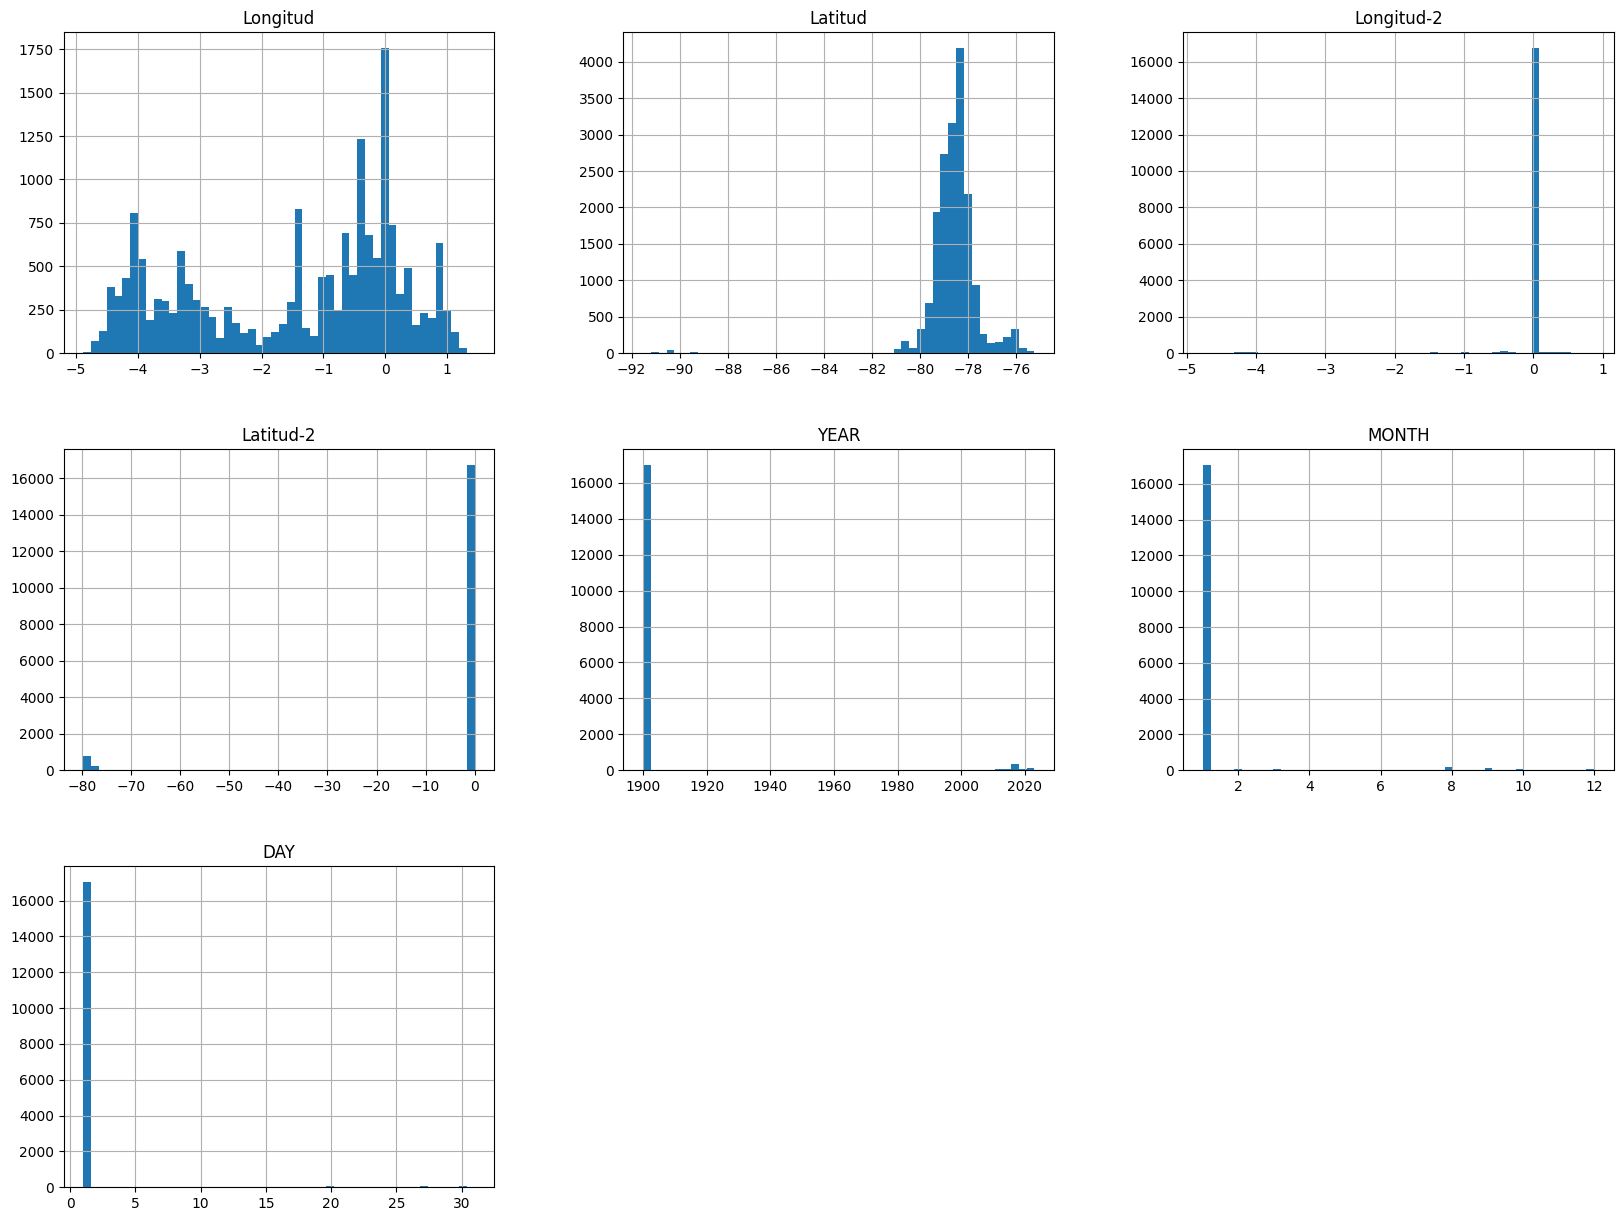

In [102]:
# Represento gráficamente los atributos
df1.hist(bins=50, figsize=(20,15))
plt.show()

In [103]:
# Copiamos el conjunto de datos para no alterar el original
df_starup = df1.copy()

In [104]:
## Filtrar datos por un atributo
#df1 = df1_copy
#df_starup = df1.loc[df1['OSOS'] == "SI"]
#df_starup.tail(10)

### Análisis de correlaciones

In [105]:

##columnas_categoricas = ['Provincia','Canton','Parroquia','Alimentacion','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','tipo_ecosi','AREA PROTEGIDA','Deficit Hidrico','fragilidad']
columnas_categoricas = ['PROVINCIA','CANTON','PARROQUIA','ALIMENTACION','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','TIPO_ECOSI','AREA PROTEGIDA','DEFICIT HIDRICO','FRAGILIDAD']
le = LabelEncoder()
df_starup[columnas_categoricas] = df_starup [columnas_categoricas].apply(lambda col: le.fit_transform(col.astype(str)))

In [106]:
df_starup.tail(10)

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
17729,18,139,479,0,0,14,0.16666,-78.58333,0.0,0.0,4,2,2,0,4,13,1900,1,1
17730,14,161,530,0,0,22,-2.70000,-78.30000,0.0,0.0,4,1,2,0,4,0,1900,1,1
17731,15,135,555,0,0,29,-0.53333,-77.78333,0.0,0.0,0,1,1,2,5,0,1900,1,1
17732,18,129,409,0,0,14,0.00000,-79.20000,0.0,0.0,4,1,2,0,4,13,1900,1,1
17733,12,17,364,0,0,28,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17734,12,17,364,0,0,22,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17735,12,17,364,0,0,14,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17736,12,17,364,0,0,7,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17737,12,17,364,0,0,1,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17738,0,38,611,0,0,28,-3.10000,-79.08333,0.0,0.0,4,2,2,0,4,11,1900,1,1


In [107]:
# Mostrar la correlación entre los atributos conjunto de datos
corr_matrix = df_starup.corr()
corr_matrix["OSOS"].sort_values(ascending=False)

OSOS               1.000000
YEAR               0.840384
DAY                0.748171
MONTH              0.737025
PROVINCIA          0.112658
PARROQUIA          0.051891
FRAGILIDAD         0.026526
Latitud            0.021628
CANTON             0.020348
ALIMENTACION       0.018500
AREA PROTEGIDA     0.006726
Longitud           0.003626
INCENDIOS          0.001586
TIPO VEGETACION   -0.015152
BIOCLIMA          -0.075934
TIPO_ECOSI        -0.082489
DEFICIT HIDRICO   -0.112627
Longitud-2        -0.607565
Latitud-2         -0.999984
Name: OSOS, dtype: float64

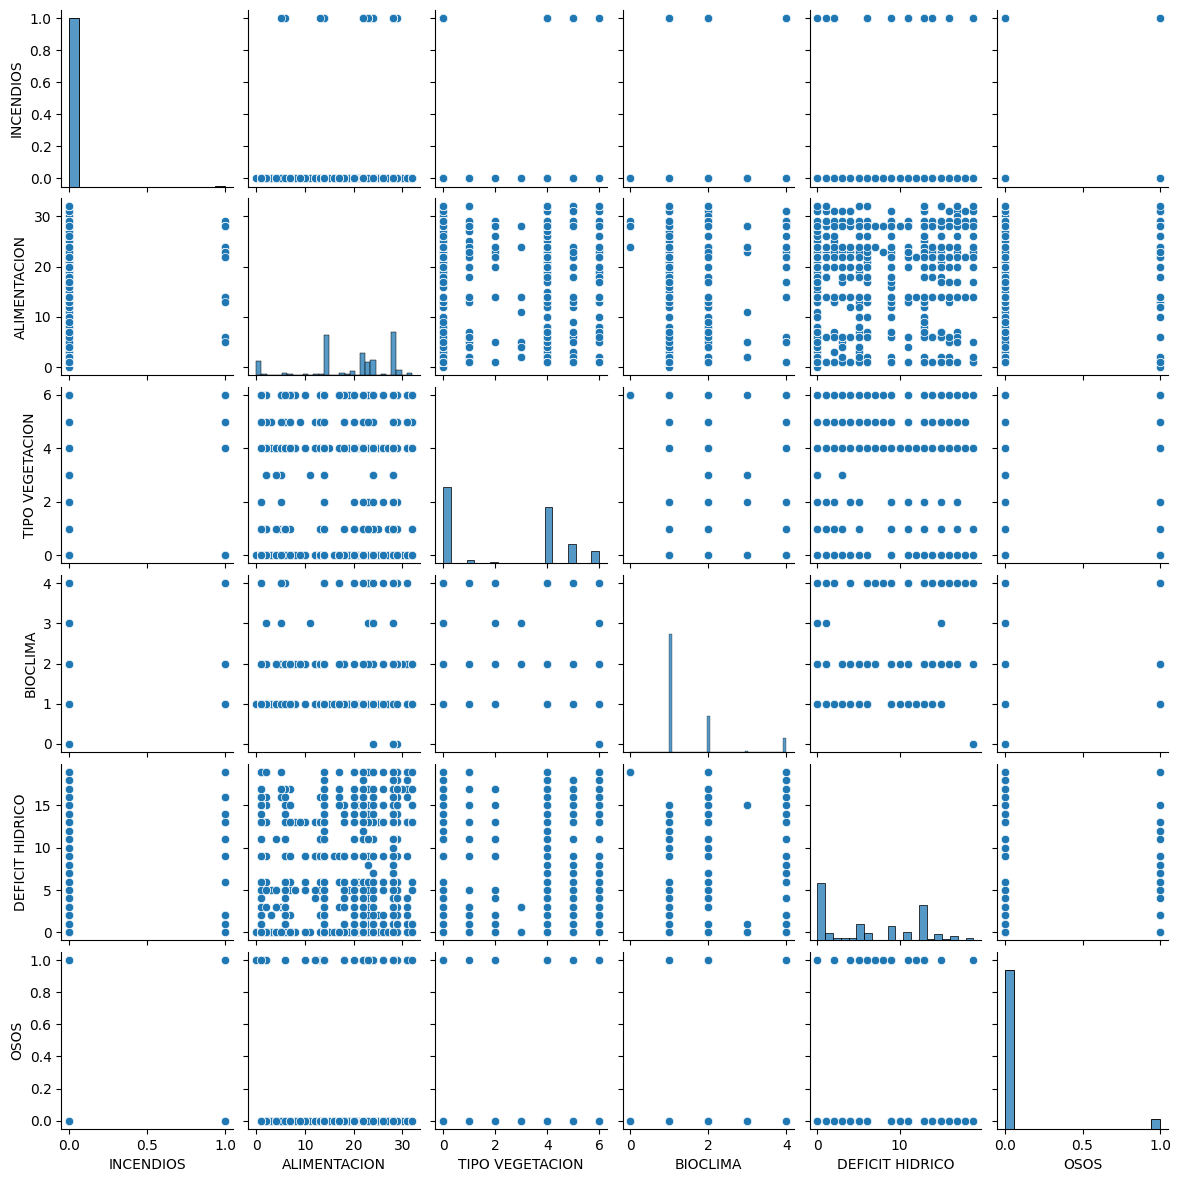

In [108]:
columnas = ["INCENDIOS","ALIMENTACION","TIPO VEGETACION","BIOCLIMA","DEFICIT HIDRICO","OSOS"]
sns.pairplot(df_starup[columnas], diag_kind="auto",height =2)


In [109]:
# Mostrar correlación lineal entre todos los atributos del conjunto de datos
df_starup.corr()

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
PROVINCIA,1.000000,0.099274,0.195162,-0.026953,0.112658,-0.135685,-0.095255,0.221388,-0.147157,-0.112961,-0.113492,-0.143320,-0.153786,0.155686,0.096610,-0.187634,0.107139,0.097904,0.107231
CANTON,0.099274,1.000000,0.077074,-0.019903,0.020348,0.071127,0.158017,-0.067732,-0.073844,-0.020727,-0.003609,-0.018150,0.052248,-0.037712,-0.012736,0.043404,0.017253,0.014686,0.015077
PARROQUIA,0.195162,0.077074,1.000000,-0.008307,0.051891,0.048955,-0.299277,-0.095956,-0.128652,-0.052432,0.054777,0.015557,-0.045001,0.013472,-0.137034,-0.033755,0.032444,0.032242,0.027658
INCENDIOS,-0.026953,-0.019903,-0.008307,1.000000,0.001586,0.023822,-0.001858,-0.012203,0.006214,-0.001528,0.038506,0.020426,0.030733,-0.025024,0.004085,0.041973,0.006487,0.007019,-0.001458
OSOS,0.112658,0.020348,0.051891,0.001586,1.000000,0.018500,0.003626,0.021628,-0.607565,-0.999984,-0.015152,-0.075934,-0.082489,0.026526,0.006726,-0.112627,0.840384,0.737025,0.748171
ALIMENTACION,-0.135685,0.071127,0.048955,0.023822,0.018500,1.000000,-0.071689,-0.222402,-0.008016,-0.018472,0.214357,0.234491,0.117505,-0.149616,-0.035533,0.239030,0.010962,-0.000249,-0.006893
Longitud,-0.095255,0.158017,-0.299277,-0.001858,0.003626,-0.071689,1.000000,0.219526,0.199218,-0.002508,0.055601,0.037867,0.115493,-0.121573,0.105284,0.138370,0.021309,0.008915,0.007332
Latitud,0.221388,-0.067732,-0.095956,-0.012203,0.021628,-0.222402,0.219526,1.000000,0.044612,-0.021105,-0.148910,-0.338281,-0.203534,0.234336,0.048160,-0.334645,0.026874,0.020014,0.023165
Longitud-2,-0.147157,-0.073844,-0.128652,0.006214,-0.607565,-0.008016,0.199218,0.044612,1.000000,0.611051,0.052776,0.072560,0.072992,-0.037627,-0.010434,0.065739,-0.452352,-0.427486,-0.439013
Latitud-2,-0.112961,-0.020727,-0.052432,-0.001528,-0.999984,-0.018472,-0.002508,-0.021105,0.611051,1.000000,0.015389,0.075911,0.082429,-0.026332,-0.006560,0.112316,-0.839871,-0.736787,-0.747767


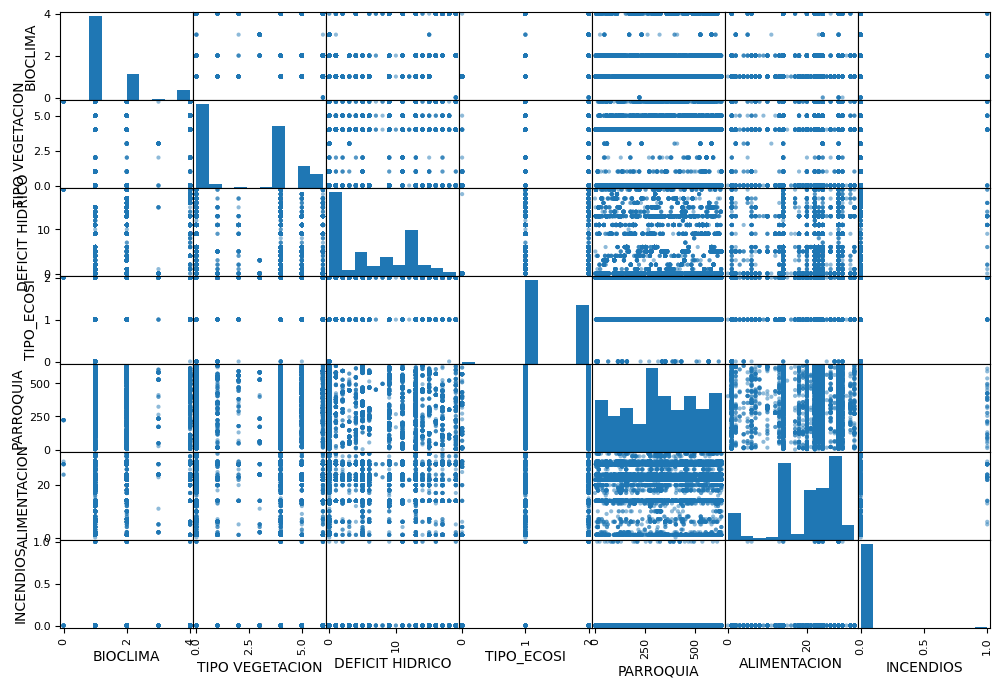

In [110]:
# Representar gráficamente las correlaciones

from pandas.plotting import scatter_matrix

attributes = ["BIOCLIMA", "TIPO VEGETACION", "DEFICIT HIDRICO", "TIPO_ECOSI","PARROQUIA","ALIMENTACION","INCENDIOS"]

scatter_matrix(df_starup[attributes], figsize=(12,8))
plt.show()

### Selección de atributos

In [366]:
# Seleccionamos aquellas variables que tienen mayor correlacion
columnas= ["BIOCLIMA", "TIPO VEGETACION","DEFICIT HIDRICO", "ALIMENTACION","PARROQUIA","OSOS","YEAR","MONTH","DAY","Latitud","Longitud"]
df_seleccion = df1[columnas]
df_seleccion.tail()

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,OSOS,YEAR,MONTH,DAY,Latitud,Longitud
17734,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Pitcairnia,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17735,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Guzmania,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17736,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Catopsis,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17737,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17738,PLUVIESTACIONAL,TIERRA AGROPECUARIA,450 - 475,Tillandsia,VICTORIA DEL PORTETE (IRQUIS),NO,1900,1,1,-79.08333,-3.10000


### División del conjunto de datos

In [367]:
#Definir tamaño de la muestra
test_porcentaje = 0.40
val_porcentaje = 0.50
df = df_seleccion
var_stratify = 'OSOS'
train_set, val_set, test_set = train_val_test_split(df, stratify=var_stratify)

In [113]:
print("Longitud del conjunto de datos:", len(df))

Longitud del conjunto de datos: 17739


In [114]:
print("Longitud del conjunto de Entrenamiento Set:", len(train_set))
print("Longitud del conjunto de Validacion:", len(val_set))
print("Longitud del conjunto de pruebas:", len(test_set))

Longitud del conjunto de Entrenamiento Set: 10643
Longitud del conjunto de Validacion: 3548
Longitud del conjunto de pruebas: 3548


<Axes: >

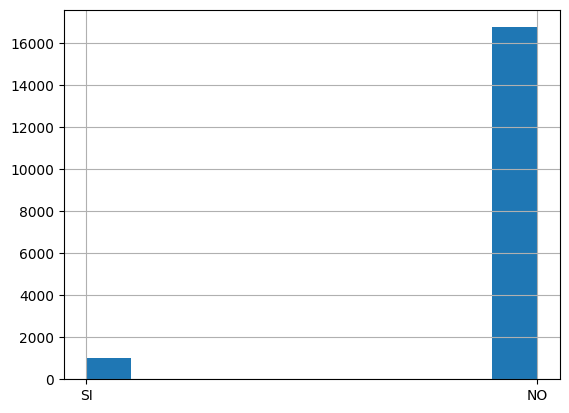

In [115]:
# Comprobación de que stratify mantiene la proporcion de la característica en los conjuntos
%matplotlib inline
import matplotlib.pyplot as plt
df[var_stratify].hist()

<Axes: >

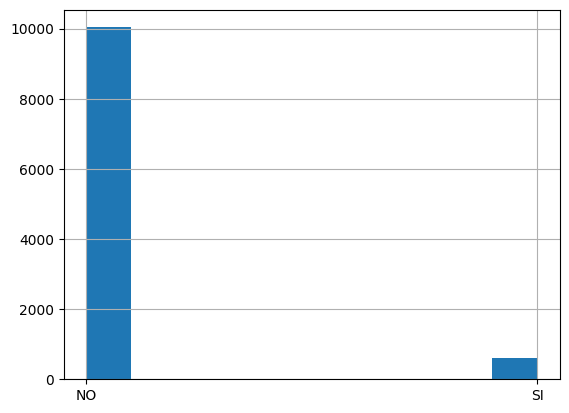

In [116]:
train_set[var_stratify].hist()

<Axes: >

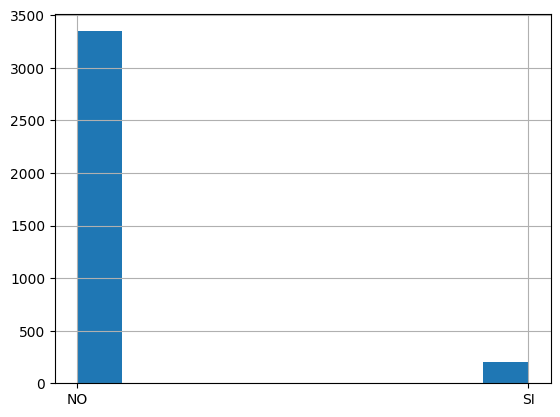

In [117]:
val_set[var_stratify].hist()

<Axes: >

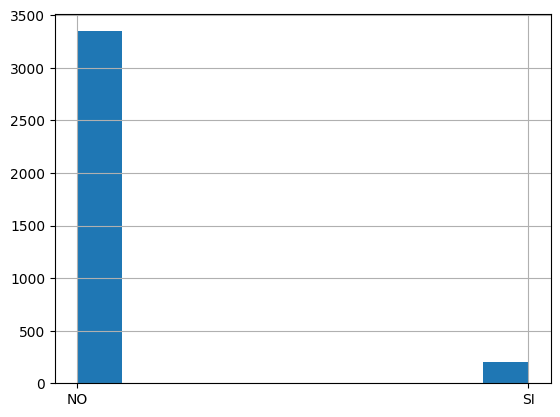

In [118]:
test_set[var_stratify].hist()

Como se observa los 3 conjuntos de datos de entrenamiento, validación y pruebas
mantienen la misma proporción


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [368]:
# Conjunto de datos general
X_df = df.drop(var_stratify, axis=1)
y_df = df[var_stratify].copy()

In [120]:
#y_df.info()

In [369]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop(var_stratify, axis=1)
y_train = train_set[var_stratify].copy()

In [370]:
# Conjunto de datos de validación
X_val = val_set.drop(var_stratify, axis=1)
y_val = val_set[var_stratify].copy()

In [371]:
# Conjunto de datos de pruebas
X_test = test_set.drop(var_stratify, axis=1)
y_test = test_set[var_stratify].copy()

### Preparación del conjunto de datos

In [372]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()


In [125]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BIOCLIMA         17739 non-null  object 
 1   TIPO VEGETACION  17739 non-null  object 
 2   DEFICIT HIDRICO  17739 non-null  object 
 3   ALIMENTACION     17739 non-null  object 
 4   PARROQUIA        17739 non-null  object 
 5   YEAR             17739 non-null  int64  
 6   MONTH            17739 non-null  int64  
 7   DAY              17739 non-null  int64  
 8   Latitud          17739 non-null  float64
 9   Longitud         17739 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 1.4+ MB


In [373]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


DataFramePreparer()

In [374]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [375]:
X_train.head(5)

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,YEAR,MONTH,DAY,Latitud,Longitud
13107,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,AHUANO,1900,1,1,-77.58000,-1.03000
8815,PLUVIAL,BOSQUE,775 - 800,Guzmania,TULULBI (CAB. EN RICAURTE),1900,1,1,-78.60000,1.03333
586,PLUVIAL,BOSQUE,375 - 400,Gregbrownia,LOJA,1900,1,1,-79.16670,-4.00830
17579,PLUVIESTACIONAL,BOSQUE,140 - 150,Guzmania,LAS PAMPAS,1900,1,1,-79.00672,-0.42639
6032,PLUVIAL,TIERRA AGROPECUARIA,70 - 80,Tillandsia,MARIANO ACOSTA,1900,1,1,-77.95000,0.30000


In [376]:
## Visualización de los datos transformados
X_train_prep.head(5)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.124369,-0.060394,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078631,0.581388,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.747004,-0.986770,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.558322,0.127354,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.687987,0.353292,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [377]:
# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)

### Entrenamiento de un algoritmo de Regresión Logística

Para realizar la instanciación de un algoritmo se utiliza una libreria de sklearn

In [378]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100)
clf.fit(X_train_prep, y_train)

LogisticRegression()

### Predicción 

Se procede a realizar la predicción con el conjunto de validación 

In [379]:
y_pred = clf.predict(X_val_prep)

In [382]:
from sklearn.metrics import confusion_matrix


In [383]:
matrix_rl= confusion_matrix(y_val, y_pred)
print(matrix_rl)

[[3343    4]
 [  47  154]]


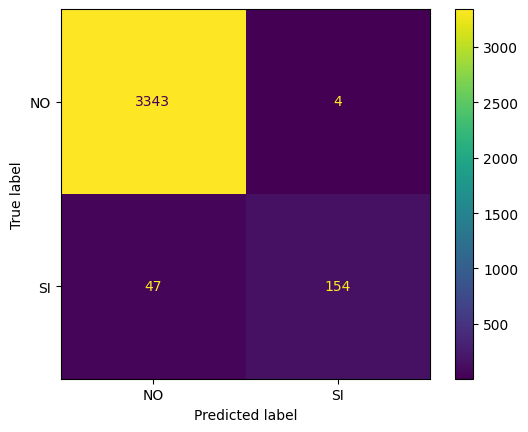

In [384]:
## Generar matriz de confusion
#X_test_prep, y_test
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,     display_labels=clf.classes_)
disp.plot()
plt.show()



### Métricas derivadas de la matriz de confusión


In [385]:
## etiqueta evaluación
var_eva = 'NO'

#### Precisión


In [386]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, pos_label=var_eva))

Precisión: 0.9861356932153392


#### Recall

In [387]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label=var_eva))

F1 score: 0.9924298649250408


#### F1 Score

In [388]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label=var_eva))

F1 score: 0.9924298649250408


### Curvas ROC y PR

#### Curva Roc

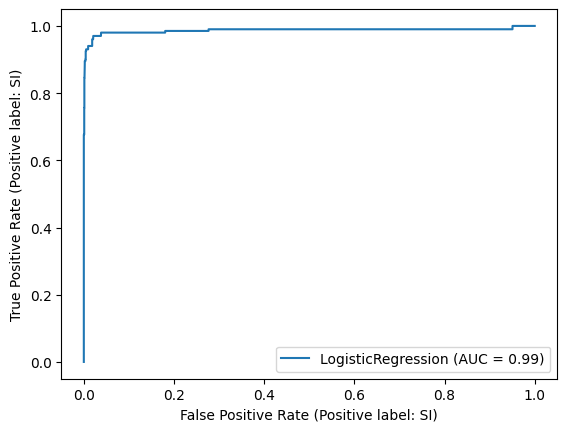

In [140]:
from sklearn.metrics import RocCurveDisplay

# Creamos la visualización
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

# Mostramos la visualización
plt.show()


### Curva Pr

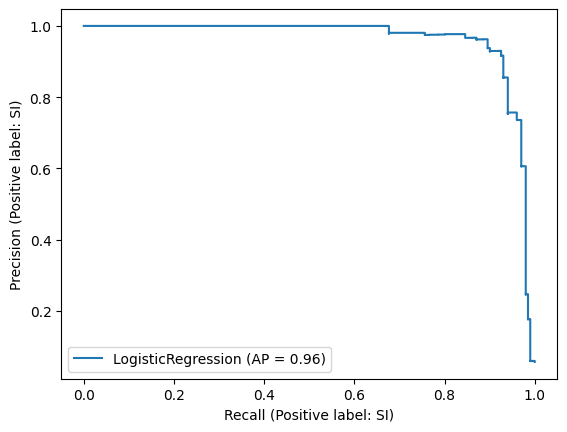

In [389]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator( clf, X_val_prep, y_val)

plt.show()


### Evaluación del modelo datos de pruebas

In [394]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

In [395]:
y_pred = clf.predict(X_test_prep)

In [392]:
matrix_rl_test = confusion_matrix(y_test, y_pred)
print(matrix_rl_test)

[[3342    5]
 [  38  163]]


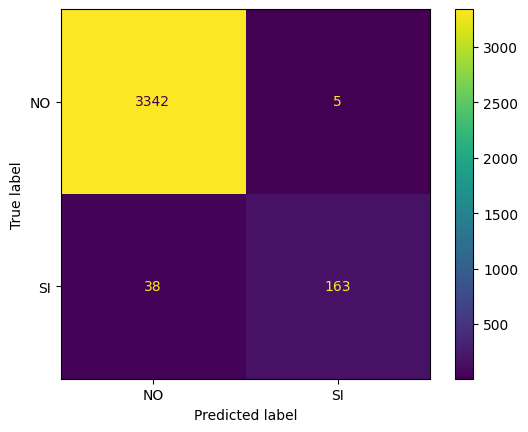

In [396]:
cm_test = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,     display_labels=clf.classes_)
disp.plot()
plt.show()

In [397]:
print("F1 score:", f1_score(y_test, y_pred, pos_label='NO'))

F1 score: 0.9936078489668501


### Entrenamiento Random Forest


In [338]:
def seleccionar_atributos(df1, columnas):
    df_seleccion = df1[columnas]
    df_seleccion.tail()
    return (df_seleccion)

### Division del conjunto de datos

In [404]:
columnas= ["BIOCLIMA", "TIPO VEGETACION","DEFICIT HIDRICO", "ALIMENTACION","PARROQUIA","OSOS","YEAR","MONTH","DAY","Latitud","Longitud"]
df = seleccionar_atributos(df1, columnas)
df.head(3)

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,OSOS,YEAR,MONTH,DAY,Latitud,Longitud
0,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Racinaea,PAPALLACTA,SI,2021,2,27,-78.149224,-0.346344
1,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Guzmania,NANEGALITO,SI,2023,10,27,-78.725718,0.067263
2,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Racinaea,PAPALLACTA,SI,2012,12,31,-78.092331,-0.370960


In [420]:
#Definir tamaño de la muestra
test_porcentaje = 0.40
val_porcentaje = 0.50
df = df_seleccion
var_stratify = 'OSOS'
train_set_rf, val_set_rf, test_set_rf = train_val_test_split(df, stratify=var_stratify)

Separar las etiquetas de los datos entrenamiento, validación y pruebas 

In [421]:
X_df_rf, y_df_rf = remove_labels(df, var_stratify)
X_train_rf, y_train_rf = remove_labels(train_set_rf, var_stratify)
X_val_rf, y_val_rf = remove_labels(val_set_rf, var_stratify)
X_test_rf, y_test_rf = remove_labels(test_set_rf, var_stratify)

In [422]:
print("Longitud del conjunto de datos:", len(df))
print("Longitud del conjunto de Entrenamiento Set:", len(train_set_rf))
print("Longitud del conjunto de Validacion:", len(val_set_rf))
print("Longitud del conjunto de pruebas:", len(test_set_rf))

Longitud del conjunto de datos: 17739
Longitud del conjunto de Entrenamiento Set: 10643
Longitud del conjunto de Validacion: 3548
Longitud del conjunto de pruebas: 3548


In [424]:
# Los conjuntos de datos tienen datos categóricos por los que hay que transformar
# Instanciamos nuestro transformador personalizado para verificar valores vacíos
data_preparer = DataFramePreparer()

In [426]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df_rf)

c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


DataFramePreparer()

In [427]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep_rf = data_preparer.transform(X_train_rf)

In [428]:
X_train_rf.head(5)

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,YEAR,MONTH,DAY,Latitud,Longitud
13107,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,AHUANO,1900,1,1,-77.58000,-1.03000
8815,PLUVIAL,BOSQUE,775 - 800,Guzmania,TULULBI (CAB. EN RICAURTE),1900,1,1,-78.60000,1.03333
586,PLUVIAL,BOSQUE,375 - 400,Gregbrownia,LOJA,1900,1,1,-79.16670,-4.00830
17579,PLUVIESTACIONAL,BOSQUE,140 - 150,Guzmania,LAS PAMPAS,1900,1,1,-79.00672,-0.42639
6032,PLUVIAL,TIERRA AGROPECUARIA,70 - 80,Tillandsia,MARIANO ACOSTA,1900,1,1,-77.95000,0.30000


In [429]:
## Visualización de los datos transformados
X_train_prep_rf.head(5)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.124369,-0.060394,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078631,0.581388,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.747004,-0.986770,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.558322,0.127354,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.687987,0.353292,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
# Transformamos el subconjunto de datos de validacion
X_val_prep_rf = data_preparer.transform(X_val_rf)

In [431]:
# Transformamos el subconjunto de datos de prueba
X_test_prep_rf = data_preparer.transform(X_test_rf)

### Escalar el conjunto de datos

Se realiza un escalado al conjunto de datos y se va a comparr con los resultados sin escalar

In [432]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_prep_rf)

scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test_prep_rf)

scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val_prep_rf)

In [433]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns=X_train_prep_rf.columns, index=X_train_prep_rf.index)
X_train_scaled.head(10)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.122000,-0.061167,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078466,0.580554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.745431,-0.987455,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.557146,0.126563,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.686537,0.352480,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16301,0.0,0.0,0.0,-1.679087,-0.754102,0.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15235,0.0,0.0,0.0,0.117693,-0.725694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13396,0.0,0.0,0.0,1.902703,-0.129589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,0.0,0.0,0.0,0.163793,-0.663321,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7228,0.0,0.0,0.0,-0.984347,-1.129058,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [434]:
X_train_scaled.describe()

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
count,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,...,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.00000,10643.000000,10643.000000,10643.000000,10643.000000
mean,4.871747,0.264869,0.737104,-0.057747,-0.188258,0.000564,-0.300855,0.214507,0.004604,0.081180,...,0.015221,0.000094,0.000470,0.000282,0.000094,0.00094,0.000282,0.000376,0.017664,0.001128
std,23.388373,1.440557,3.943198,1.301623,0.531819,0.023738,0.458651,0.410499,0.067699,0.273124,...,0.122438,0.009693,0.021671,0.016788,0.009693,0.03064,0.016788,0.019384,0.131734,0.033561
min,0.000000,0.000000,0.000000,-15.286958,-1.249234,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.588075,-0.742413,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.411925,0.257587,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,123.000000,11.000000,30.000000,3.864241,0.708766,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


xxxxxxxx Cambio

In [350]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_prep_rf)

In [351]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test_prep_rf)

In [352]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val_prep_rf)

In [353]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns=X_train_prep_rf.columns, index=X_train_prep_rf.index)
X_train_scaled.head(10)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.122000,-0.061167,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078466,0.580554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.745431,-0.987455,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.557146,0.126563,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.686537,0.352480,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16301,0.0,0.0,0.0,-1.679087,-0.754102,0.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15235,0.0,0.0,0.0,0.117693,-0.725694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13396,0.0,0.0,0.0,1.902703,-0.129589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,0.0,0.0,0.0,0.163793,-0.663321,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7228,0.0,0.0,0.0,-0.984347,-1.129058,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [435]:
X_train_scaled.describe()

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
count,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,...,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.00000,10643.000000,10643.000000,10643.000000,10643.000000
mean,4.871747,0.264869,0.737104,-0.057747,-0.188258,0.000564,-0.300855,0.214507,0.004604,0.081180,...,0.015221,0.000094,0.000470,0.000282,0.000094,0.00094,0.000282,0.000376,0.017664,0.001128
std,23.388373,1.440557,3.943198,1.301623,0.531819,0.023738,0.458651,0.410499,0.067699,0.273124,...,0.122438,0.009693,0.021671,0.016788,0.009693,0.03064,0.016788,0.019384,0.131734,0.033561
min,0.000000,0.000000,0.000000,-15.286958,-1.249234,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.588075,-0.742413,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.411925,0.257587,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,123.000000,11.000000,30.000000,3.864241,0.708766,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Decision Forest

In [436]:
# Modelo entrenado con el conjunto de datos sin escalar
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train_prep_rf, y_train_rf)

DecisionTreeClassifier(random_state=42)

In [437]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred_rf = clf_tree.predict(X_train_prep_rf)

In [438]:
print("F1 Score Train Set:", f1_score(y_train_pred_rf, y_train_rf, average='weighted'))

F1 Score Train Set: 0.9986785054708796


In [439]:
# Predecimos con el conjunto de datos de validación
y_val_pred_rf = clf_tree.predict(X_val_prep_rf)

In [440]:
# Comparamos resultados entre escalado y sin escalar
print("F1 Score Validation Set:", f1_score(y_val_pred_rf, y_val_rf, average='weighted'))

F1 Score Validation Set: 0.9983049732547344


### Random Forest

In [441]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_prep_rf, y_train_rf)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [442]:
# Modelo entrenado con el conjunto de datos escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled, y_train_rf)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [443]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred_rf = clf_tree.predict(X_train_prep_rf)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [365]:
#X_train_scaled.head()

In [444]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred_rf, y_train_rf, y_train_prep_pred, y_train_rf, f1_score)


f1_score WITHOUT preparation: 0.9986785054708796
f1_score WITH preparation: 0.9986785054708796


In [446]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val_prep)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [448]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val_rf, y_prep_pred, y_val_rf, f1_score)

f1_score WITHOUT preparation: 0.9980293701807661
f1_score WITH preparation: 0.9969180283063976


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
# La clase imputer no admite valores categoricos, eliminamos los atributos categoricos
X_train_copy_num = X_train_copy.select_dtypes(exclude=['object'])
X_train_copy_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10643 entries, 13107 to 3180
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      10643 non-null  int64  
 1   MONTH     10643 non-null  int64  
 2   DAY       10643 non-null  int64  
 3   Latitud   10643 non-null  float64
 4   Longitud  10643 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 498.9 KB


In [ ]:

# Se le proporcionan los atributos numericos para que calcule los valores
imputer.fit(X_train_copy_num)

SimpleImputer(strategy='median')

In [ ]:
# Rellenamos los valores nulos
X_train_copy_num_nonan = imputer.transform(X_train_copy_num)

In [ ]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_copy = pd.DataFrame(X_train_copy_num_nonan, columns=X_train_copy_num.columns)

In [ ]:
X_train_copy.head(10)

,YEAR,MONTH,DAY,Latitud,Longitud
0,1900.0,1.0,1.0,-77.58000,-1.03000
1,1900.0,1.0,1.0,-78.60000,1.03333
2,1900.0,1.0,1.0,-79.16670,-4.00830
3,1900.0,1.0,1.0,-79.00672,-0.42639
4,1900.0,1.0,1.0,-77.95000,0.30000
5,1900.0,1.0,1.0,-79.96000,-3.25800
6,1900.0,1.0,1.0,-78.43333,-3.16666
7,1900.0,1.0,1.0,-76.91666,-1.25000
8,1900.0,1.0,1.0,-78.39416,-2.96611
9,1900.0,1.0,1.0,-79.36970,-4.46360


### Transformacion de datos categóricos


In [ ]:
X_train = train_set.drop(var_stratify, axis=1)
y_train = train_set[var_stratify].copy()

Para por trabajar con algoritmos de Machine Learning se debe transformar los valores categóricos a valores númericos

In [ ]:
## Verificación de la transformación
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PROVINCIA        17739 non-null  object 
 1   CANTON           17739 non-null  object 
 2   PARROQUIA        17739 non-null  object 
 3   INCENDIOS        17739 non-null  object 
 4   OSOS             17739 non-null  object 
 5   ALIMENTACION     17739 non-null  object 
 6   Longitud         17739 non-null  float64
 7   Latitud          17739 non-null  float64
 8   Longitud-2       17739 non-null  float64
 9   Latitud-2        17739 non-null  float64
 10  TIPO VEGETACION  17739 non-null  object 
 11  BIOCLIMA         17739 non-null  object 
 12  TIPO_ECOSI       17739 non-null  object 
 13  FRAGILIDAD       17739 non-null  object 
 14  AREA PROTEGIDA   17739 non-null  object 
 15  DEFICIT HIDRICO  17739 non-null  object 
 16  YEAR             17739 non-null  int64  
 17  MONTH       

In [ ]:
## Respalddo del dataset
df1_copy = pd.read_csv(url1, sep=sep,encoding = encoding)

In [ ]:
## Actualizar tipo de datos
df1['year'] = df1['year'].astype('int')
df1['month'] = df1['month'].astype('int')
df1['day'] = df1['day'].astype('int')
df1['Provincia'] = df1['Provincia'].astype('category')
df1['Canton'] = df1['Canton'].astype('category')
df1['Parroquia'] = df1['Parroquia'].astype('category')
df1['Alimentacion'] = df1['Alimentacion'].astype('category')
df1['INCENDIOS'] = df1['INCENDIOS'].astype('category')
df1['OSOS'] = df1['OSOS'].astype('category')
df1['TIPO VEGETACION'] = df1['TIPO VEGETACION'].astype('category')
df1['BIOCLIMA'] = df1['BIOCLIMA'].astype('category')
df1['tipo_ecosi'] = df1['tipo_ecosi'].astype('category')
df1['fragilidad'] = df1['fragilidad'].astype('category')
df1['AREA PROTEGIDA'] = df1['AREA PROTEGIDA'].astype('category')
df1['Deficit Hidrico'] = df1['Deficit Hidrico'].astype('category')


In [ ]:
## Seleccionar todos los datos

df_starup = df1_copy
df_starup.head(10)


,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY,Deficit Hidrico
0,7,41,291,0,1,17,-0.346344,-78.149224,-0.345021,-78.152762,4,1,1,5,6,0,2021,2,27,NaN
1,10,45,255,0,1,6,0.067263,-78.725718,0.070942,-78.727948,4,1,2,0,5,0,2023,10,27,NaN
2,7,41,291,0,1,17,-0.370960,-78.092331,-0.378412,-78.092185,4,1,2,0,5,0,2012,12,31,NaN
3,15,46,370,0,1,6,-1.211674,-78.129240,-1.264861,-78.158727,0,1,1,2,6,0,2020,3,19,NaN
4,10,45,314,0,1,16,-0.448138,-78.332337,-0.440126,-78.323844,2,1,1,4,5,0,2021,7,4,NaN
5,10,45,254,0,1,6,0.116248,-78.600134,0.112280,-78.602313,4,2,1,1,5,5,2012,12,10,NaN
6,10,45,255,0,1,6,0.120953,-78.724692,0.122838,-78.727219,4,1,2,0,5,0,2017,9,26,NaN
7,10,45,255,0,1,6,0.120953,-78.724692,0.103750,-78.722376,4,1,2,0,5,0,2017,11,28,NaN
8,10,45,255,0,1,6,0.120953,-78.724692,0.106072,-78.721904,4,1,2,0,5,0,2015,8,31,NaN
9,10,45,254,0,1,25,0.095081,-78.616742,0.091183,-78.620961,0,2,1,1,5,5,2015,9,27,NaN


In [ ]:
# Separamos el conjunto de datos 60% train set, 40% test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_seleccion, test_size=0.4, random_state=42)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10643 entries, 15154 to 15795
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   BIOCLIMA         10643 non-null  int32
 1   TIPO VEGETACION  10643 non-null  int32
 2   DEFICIT HIDRICO  10643 non-null  int32
 3   ALIMENTACION     10643 non-null  int32
 4   PARROQUIA        10643 non-null  int32
 5   OSOS             10643 non-null  int32
dtypes: int32(6)
memory usage: 332.6 KB


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7096 entries, 14353 to 8827
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   BIOCLIMA         7096 non-null   int32
 1   TIPO VEGETACION  7096 non-null   int32
 2   DEFICIT HIDRICO  7096 non-null   int32
 3   ALIMENTACION     7096 non-null   int32
 4   PARROQUIA        7096 non-null   int32
 5   OSOS             7096 non-null   int32
dtypes: int32(6)
memory usage: 221.8 KB


In [ ]:
# Separamos el conjunto de datos de pruebas 50% validation set, 50% test set
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=42)

In [ ]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 10643
Longitud del Validation Set: 3548
Longitud del Test Set: 3548


### 3. EDA de dataset

Preprocesamiento: quitar espacios de cantidades numéricas

In [ ]:
df_oso_stats = df_starup.describe()
df_oso_stats = df_oso_stats.transpose()
df_oso_stats


,count,mean,std,min,25%,50%,75%,max
Provincia,17739.0,9.884492,6.005468,0.000000,6.00000,10.000000,14.00000,24.000000
Canton,17739.0,85.596651,53.498468,0.000000,45.00000,77.000000,130.00000,186.000000
Parroquia,17739.0,307.275269,181.530123,0.000000,177.50000,290.000000,476.00000,633.000000
INCENDIOS,17739.0,0.002650,0.051407,0.000000,0.00000,0.000000,0.00000,1.000000
OSOS,17739.0,0.056711,0.231296,0.000000,0.00000,0.000000,0.00000,1.000000
Alimentacion,17739.0,13.881222,7.242738,0.000000,6.00000,15.000000,21.00000,32.000000
Longitud,17739.0,-1.455784,1.709962,-4.883330,-3.23166,-0.835833,-0.01666,1.445570
Latitud,17739.0,-78.583672,1.095658,-91.522200,-79.03333,-78.533330,-78.18545,-75.250000
Longitud-2,17739.0,-0.081301,0.545760,-4.768980,0.00000,0.000000,0.00000,0.875699
Latitud-2,17739.0,-4.450991,18.153640,-79.742839,0.00000,0.000000,0.00000,0.000000


## Análisis estadístico

In [ ]:
columna1 = 'OSOS'
columna2 = 'Alimentacion'
data = df_starup[[columna1,columna2]]
data.reset_index(drop=True, inplace=True)

data.head(200)


,OSOS,Alimentacion
0,0,12
1,0,7
2,0,12
3,0,7
4,0,11
...,...,...
195,0,7
196,0,7
197,0,7
198,0,7


## ¿Cuántos clusters? (Elbow Method)

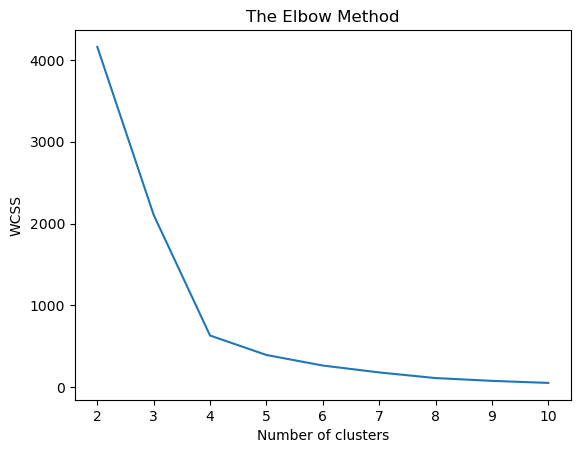

In [ ]:
# Encontrar el número de clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Con base en el gráfico inicialmente se tomó  el número de cluster = 5. Sin embargo, después del análisis se observó que no mejora el análisis de la data con relación a fijar el número de cluster en 3. Por lo cual, se continúa con número de cluster = 3, para el análisis respectivo.

##Definición de clusters k-means

In [ ]:
import warnings
xn_clusters = 3

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data)
data['cluster'] = kmeans.labels_
data.tail()


,OSOS,Alimentacion,cluster
1001,0,11,1
1002,0,11,1
1003,0,11,1
1004,0,11,1
1005,0,14,1


In [ ]:
data.head()

,OSOS,Alimentacion,cluster
0,0,12,1
1,0,7,0
2,0,12,1
3,0,7,0
4,0,11,1


#Centros y Máximos valores de los clusters

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1, columna2])
centers['freq'] = data['cluster'].value_counts()
centers['freq_r'] = data['cluster'].value_counts(normalize=True)
print(centers)

# Agrupar el DataFrame por la columna 'cluster' y obtener los valores máximos
cluster_max_values = data.groupby('cluster').max()
print(cluster_max_values)

   OSOS  Alimentacion  freq    freq_r
0   0.0      7.065844   243  0.241551
1   0.0     12.449102   668  0.664016
2   0.0      1.421053    95  0.094433
         OSOS  Alimentacion
cluster                    
0           0             9
1           0            17
2           0             4


## Visualización clusters con dos variables
Los centros en cyan

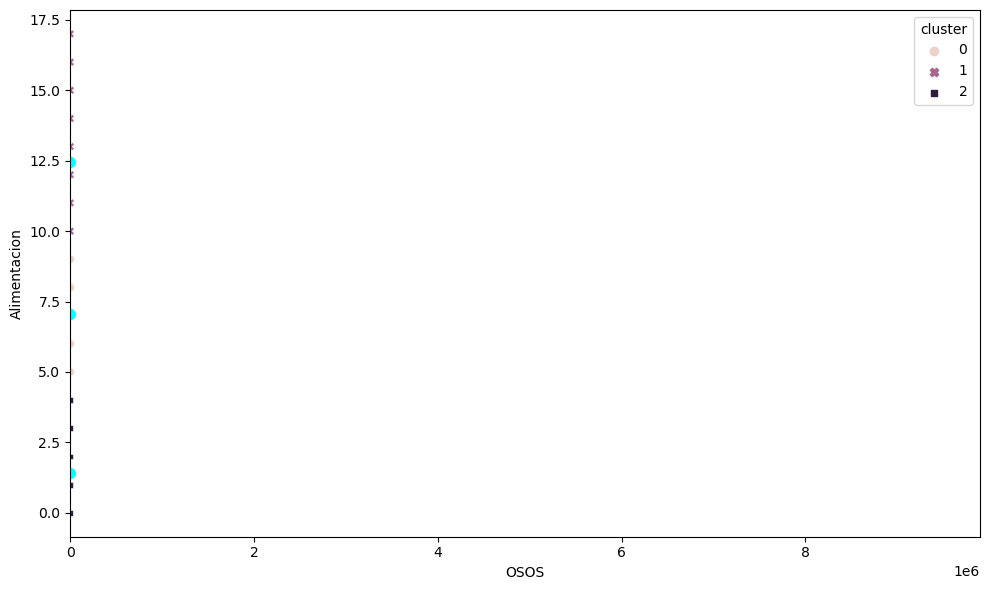

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x=columna1, y=columna2, hue='cluster', style='cluster',
                     ax=ax, data=data)
ax.set_xlim(0, 9.9e6)
#ax.set_ylim(0,)
centers.plot.scatter(x=columna1, y=columna2, ax=ax, s=50, color='cyan')
plt.tight_layout()
plt.show()

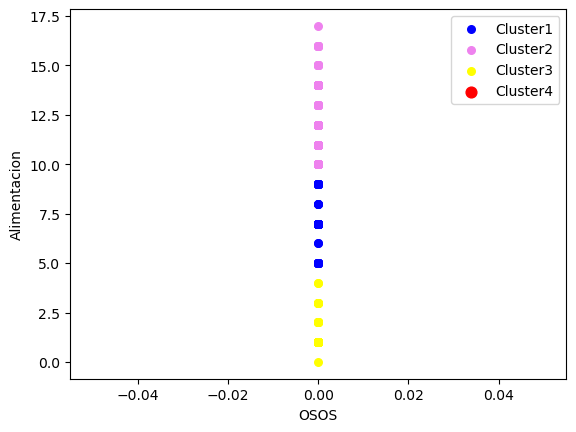

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data[data['cluster']==0][columna1], data[data['cluster']==0][columna2], s = 30, c = 'blue', label = 'Cluster1')
plt.scatter(data[data['cluster']==1][columna1], data[data['cluster']==1][columna2], s = 30, c = 'violet', label = 'Cluster2')
plt.scatter(data[data['cluster']==2][columna1], data[data['cluster']==2][columna2], s = 30, c = 'yellow', label = 'Cluster3')
plt.scatter(data[data['cluster']==3][columna1], data[data['cluster']==3][columna2], s = 60, c = 'red', label = 'Cluster4')
#plt.scatter(data[data['cluster']==4][columna1], data[data['cluster']==4][columna2], s = 60, c = 'green', label = 'Cluster5')
#plt.scatter(data[data['cluster']==5][columna1], data[data['cluster']==5][columna2], s = 60, c = 'pink', label = 'Cluster6')
#plt.scatter(data[data['cluster']==6][columna1], data[data['cluster']==6][columna2], s = 60, c = 'brown', label = 'Cluster7')
#plt.scatter(data[data['cluster']==7][columna1], data[data['cluster']==7][columna2], s = 60, c = 'cyan', label = 'Cluster8')
#plt.scatter(centers[columna1], centers[columna2], s = 100, c = 'black', label = 'Centroids')
plt.xlabel(columna1)
plt.ylabel(columna2)
plt.legend()
plt.show()

Cluster 0: Este cluster tiene un valor de "cases" de 2,376,852 y un valor de "pulmonaryConfirmado" de 13,367. Esto indica que los puntos en este cluster tienen un alto número de casos y una baja confirmación pulmonar en comparación con los otros clusters.

Cluster 1: Este cluster tiene un valor de "cases" de 617,820 y un valor de "pulmonaryConfirmado" de 908,925. Esto sugiere que los puntos en este cluster tienen un número moderado de casos y una alta confirmación pulmonar.

Cluster 2: Este cluster tiene un valor de "cases" de 9,884,100 y un valor de "pulmonaryConfirmado" de 570,237. Esto indica que los puntos en este cluster tienen un alto número de casos y una moderada confirmación pulmonar en comparación con los otros clusters. Sin embargo, los datos en este caso son solo dos y muy dispersos. Por lo cual, este cluster no es caraterizable.


## Caracterización de los clusters

+ Cluster 0: CasosCovid Alto- Tuberculosis Baja (300/1).
+ Cluster 1: CasosCovid Medio - Tuberculosis Alta (3/1).
+ Cluster 2: no caracterizable, alta dispersión.

## Aplicación de K-Means con dos variables (2)
Se selecciona las variables 'deaths' y 'pulmonaryConfirmado'. Ahora se busca ver la relación entre muertes por posible COVID y la tuberculosis diagnosticada.

##Analisis intermedio
La tuberculosis está presente cuando hay fallecimiento por posible COVID.

In [ ]:
columna1 = 'OSOS'
columna2 = 'Alimentacion'
columna3 = 'BIOCLIMA'

columnas = ['Alimentacion','BIOCLIMA','TIPO VEGETACION']
#data0 = df_starup[[columna1,columna2]]
data0 = df_starup[columnas]
data0.reset_index(drop=True, inplace=True)

data0.head(200)

,Alimentacion,BIOCLIMA,TIPO VEGETACION
0,12,0,3
1,7,0,3
2,12,0,3
3,7,0,0
4,11,0,2
...,...,...,...
195,7,1,0
196,7,1,0
197,7,1,0
198,7,1,0


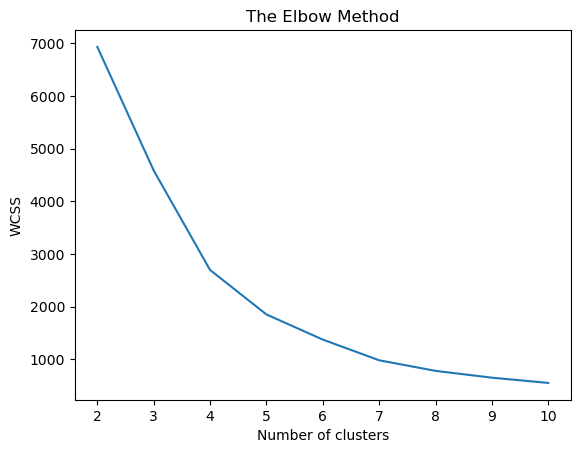

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data0)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
import warnings
xn_clusters = 4

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data0)
data0['cluster'] = kmeans.labels_
data0.tail()

,Alimentacion,BIOCLIMA,TIPO VEGETACION,cluster
1001,11,0,0,2
1002,11,0,0,2
1003,11,0,0,2
1004,11,0,0,2
1005,14,1,3,2


In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1, columna2])
centers['freq'] = data0['cluster'].value_counts()
centers['freq_r'] = data0['cluster'].value_counts(normalize=True)
print(centers)

# Agrupar el DataFrame por la columna 'cluster' y obtener los valores máximos
cluster_max_values = data0.groupby('cluster').max()
print(cluster_max_values)

ValueError: Shape of passed values is (4, 3), indices imply (4, 2)

#Visualizacion

ValueError: Could not interpret value `OSOS` for parameter `x`

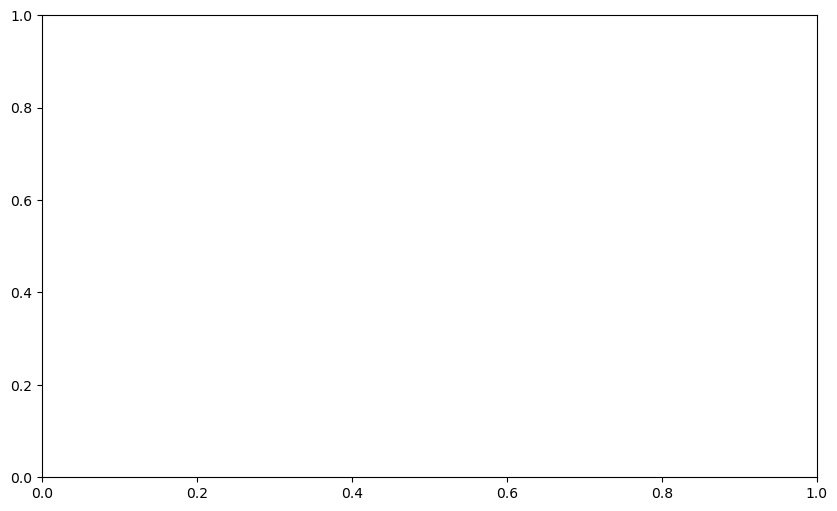

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x=columna1, y=columna2, hue='cluster', style='cluster',
                     ax=ax, data=data0)
#ax.set_xlim(0, 9.9e6)
#ax.set_ylim(0,)
centers.plot.scatter(x=columna1, y=columna2, ax=ax, s=50, color='cyan')
plt.tight_layout()
plt.show()

Se descarta la variable deaths, se descarta relación relevante entre muertes por posible COVID y tuberculosis diagnosticada.

# K-means con cuatro variables

Se analiza con mayor número de variables

In [ ]:
columna1 = 'year'
columna2 = 'OSOS'
columna3 = 'Alimentacion'
columna4 = ''
data1 = df_starup[[columna1,columna2, columna3, columna4]]
data1.reset_index(drop=True, inplace=True)
data1.head()

,year,cases,country,pulmonaryConfirmado
0,2021,0.0,0,24715
1,2020,49273.0,0,22888
2,2019,0.0,0,24358
3,2021,0.0,1,168
4,2020,48530.0,1,134


## Elbow Method

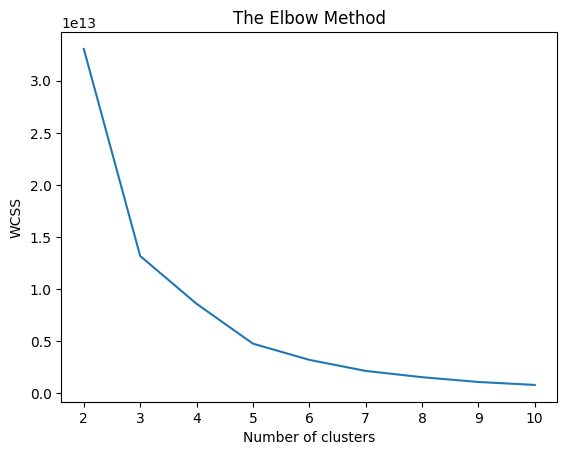

In [ ]:
from sklearn.cluster import KMeans
data_km=data1.copy()
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(data_km)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Definición de clusters

In [ ]:
import warnings
warnings.filterwarnings('ignore')
kmeans1 = KMeans(n_clusters = 5, init = "k-means++", random_state = 42).fit(data_km)
data_km['cluster'] = kmeans1.labels_

centers1 = pd.DataFrame(kmeans1.cluster_centers_, columns=[columna1,columna2, columna3, columna4])

centers1['freq']=data_km['cluster'].value_counts()
centers1['freq_r']=data_km['cluster'].value_counts(normalize=True)
centers1

,year,cases,country,pulmonaryConfirmado,freq,freq_r
0,2020.000000,4.899194e+05,97.227273,25398.590909,22,0.038261
1,2019.996317,1.040544e+04,96.896869,14206.755064,543,0.944348
2,2020.000000,9.884100e+06,78.000000,570237.000000,1,0.001739
3,2020.000000,6.901952e+06,23.000000,45728.000000,1,0.001739
4,2020.000000,1.574734e+06,83.000000,4084.125000,8,0.013913


## Clusters con data transformada (StandardScale)
## K-means

In [ ]:
from sklearn import preprocessing
data_sd = preprocessing.scale(data1)
data_sd = pd.DataFrame(data_sd, columns = [columna1,columna2, columna3, columna4])
data_sd.head()

,year,cases,country,pulmonaryConfirmado
0,1.227949,-0.146792,-1.719556,0.138368
1,0.004256,-0.056011,-1.719556,0.110887
2,-1.219436,-0.146792,-1.719556,0.132998
3,1.227949,-0.146792,-1.701747,-0.230857
4,0.004256,-0.057380,-1.701747,-0.231368


## Elbow Method

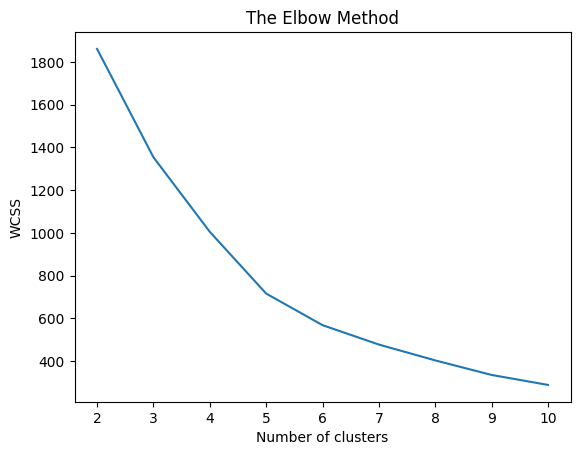

In [ ]:
data_sd_km=data_sd.copy()
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(data_sd_km)
    wcss.append(kmeans.inertia_)


import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Definición de clusters data escalada

In [ ]:
import warnings
warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = 7, init = "k-means++", random_state = 42).fit(data_sd)
data_sd_km['cluster'] = kmeans.labels_

centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1,columna2, columna3, columna4])
centers2['freq']=data_sd_km['cluster'].value_counts()
centers2['freq_r']=data_sd_km['cluster'].value_counts(normalize=True)
print(centers2)

       year      cases   country  pulmonaryConfirmado  freq    freq_r
0  0.065441   0.052533 -0.321540             2.276756    20  0.034783
1  1.227949  -0.146792  0.870426            -0.134490    93  0.161739
2 -0.614099  -0.039880  0.868829            -0.122124   188  0.326957
3 -0.614388   0.016500 -0.873919            -0.168858   180  0.313043
4  0.004256  15.316690 -0.820195             4.399148     2  0.003478
5  0.004256  -0.146792 -0.330444            13.238408     2  0.003478
6  1.227949  -0.146792 -0.869467            -0.166101    90  0.156522


In [ ]:
data2=data1.copy()
data2['cluster']=data_sd_km['cluster']
Centers_mean=data2.groupby('cluster').mean()
Centers_mean

,year,cases,country,pulmonaryConfirmado
cluster,,,,
0,2020.050000,1.081868e+05,78.500000,166880.500000
1,2021.000000,0.000000e+00,145.430108,6574.731183
2,2019.494681,5.802818e+04,145.340426,7396.867021
3,2019.494444,8.862899e+04,47.483333,4289.872222
4,2020.000000,8.393026e+06,50.500000,307982.500000
5,2020.000000,0.000000e+00,78.000000,895639.000000
6,2021.000000,0.000000e+00,47.733333,4473.155556


## Evaluación. Silhouette score

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data2['S_S'] = silhouette_samples(data_sd_km,data_sd_km['cluster'])
silhouette_score_mean = silhouette_score(data_sd_km,data_sd_km['cluster'])
print(silhouette_score_mean)

0.5511998856477928


In [ ]:
Centers_mean=data2.groupby('cluster').mean()
Centers_mean['freq']=data2['cluster'].value_counts()
Centers_mean['freq_r']=data2['cluster'].value_counts(normalize=True)
Centers_mean

,year,cases,country,pulmonaryConfirmado,S_S,freq,freq_r
cluster,,,,,,,
0,2020.050000,1.081868e+05,78.500000,166880.500000,0.274468,20,0.034783
1,2021.000000,0.000000e+00,145.430108,6574.731183,0.717737,93,0.161739
2,2019.494681,5.802818e+04,145.340426,7396.867021,0.424505,188,0.326957
3,2019.494444,8.862899e+04,47.483333,4289.872222,0.487700,180,0.313043
4,2020.000000,8.393026e+06,50.500000,307982.500000,0.362876,2,0.003478
5,2020.000000,0.000000e+00,78.000000,895639.000000,0.796589,2,0.003478
6,2021.000000,0.000000e+00,47.733333,4473.155556,0.830990,90,0.156522


# Cluster Jerárquico toma data transformada (StandardScale, data_sd)
*El clustering jerárquico es un algoritmo de agrupamiento que crea una estructura de clusters anidados en forma de un árbol o dendrograma. Este tipo de algoritmo no requiere especificar el número de clusters de antemano y es útil para visualizar la estructura de los datos en diferentes niveles de detalle.
Hay dos enfoques principales para el clustering jerárquico: el enfoque aglomerativo y el enfoque divisivo.
La función scipy.cluster.hierarchy.linkage es una función de la biblioteca SciPy que se utiliza para calcular las distancias entre pares de puntos de datos en el contexto de clustering jerárquico aglomerativo. El método de enlace "ward" minimiza la varianza total dentro de los clusters al fusionarlos.*

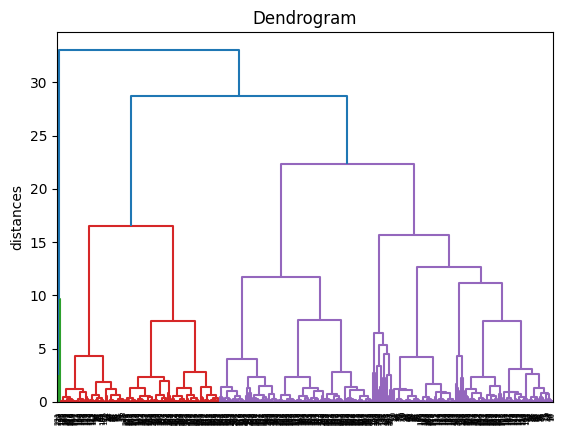

In [ ]:
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
data_sdh=data_sd.copy()
data_sdh1=data_sd.copy()
data1h=data1.copy()
dendrogram = sch.dendrogram(sch.linkage(data_sdh, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('')
plt.ylabel('distances')
plt.show()

## Definición de cluster AgglomerativeClustering y evaluación
El enfoque aglomerativo comienza con cada punto de datos como un cluster individual y fusiona iterativamente los clusters más similares hasta que todos los puntos de datos estén en un solo cluster.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(data_sdh)
data1h['cluster_hc']=y_hc
data_sdh1['cluster_hc']=y_hc
data1h['S_S_hc'] = silhouette_samples(data_sdh1,data_sdh1['cluster_hc'])
silhouette_score_mean_hc = silhouette_score(data_sdh1,data_sdh1['cluster_hc'])
print(silhouette_score_mean_hc)

0.5364155928430985


In [ ]:
Centers_mean_hc=data1h.groupby('cluster_hc').mean()
Centers_mean_hc['freq_hc']=data1h['cluster_hc'].value_counts()
Centers_mean_hc['freq_r_hc']=data1h['cluster_hc'].value_counts(normalize=True)
Centers_mean_hc

,year,cases,country,pulmonaryConfirmado,S_S_hc,freq_hc,freq_r_hc
cluster_hc,,,,,,,
0,2020.392473,1.209729e+05,52.607527,4500.553763,0.422791,186,0.323478
1,2020.615819,2.464156e+04,143.932203,5336.152542,0.460141,177,0.307826
2,2019.000000,0.000000e+00,136.727273,6666.827273,0.691304,110,0.191304
3,2020.000000,0.000000e+00,78.000000,895639.000000,0.786909,2,0.003478
4,2020.000000,8.393026e+06,50.500000,307982.500000,0.368325,2,0.003478
5,2019.000000,0.000000e+00,38.773333,4701.626667,0.845385,75,0.130435
6,2020.043478,9.407548e+04,89.260870,158559.000000,0.286832,23,0.040000


# DBSCAN toma data transformada (StandardScale, data_sd)
## Definición de clusters y evaluación
*DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en la densidad que es capaz de encontrar clusters de forma arbitraria en un conjunto de datos. A diferencia de otros algoritmos de clustering, como K-means, DBSCAN no requiere especificar el número de clusters de antemano y puede identificar puntos de datos como ruido o anomalías.*


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#pip install hdbscan
from sklearn.cluster import DBSCAN
data_sd_db=data_sd.copy()
data1_db=data1.copy()
dbscan = DBSCAN(eps=0.75, min_samples=5).fit(data_sd_db)
#y_dbs = dbscan.fit_predict(data_sd_db)
y_dbs = dbscan.labels_
data_sd_db['cluster_dbs']=y_dbs
silhouette_score(data_sd_db, data_sd_db['cluster_dbs'])

NameError: name 'data_sd' is not defined

In [ ]:
data1_db['cluster_dbs']=y_dbs
data1_db['S_S_dbs'] = silhouette_samples(data_sd_db,data_sd_db['cluster_dbs'])
silhouette_score_mean_hc = silhouette_score(data_sd_db,data_sd_db['cluster_dbs'])
Centers_mean_dbs=data1_db.groupby('cluster_dbs').mean()
Centers_mean_dbs['freq_dbs']=data1_db['cluster_dbs'].value_counts()
Centers_mean_dbs['freq_r_dbs']=data1_db['cluster_dbs'].value_counts(normalize=True)
Centers_mean_dbs
#Noisy samples are given the label -1.

,year,cases,country,pulmonaryConfirmado,S_S_dbs,freq_dbs,freq_r_dbs
cluster_dbs,,,,,,,
-1,2020.027027,903602.648649,88.918919,165113.027027,-0.178933,37,0.064348
0,2021.000000,0.000000,97.032967,5061.241758,0.437136,182,0.316522
1,2020.000000,72391.847953,97.198830,4709.789474,0.404732,171,0.297391
2,2019.000000,0.000000,97.016216,5870.124324,0.433233,185,0.321739


Cluster -1: Este cluster se etiqueta como -1, lo que indica que contiene puntos de ruido.Este cluster indica que los datos pertenecen principalmente al año 2020. Además, tiene la mayor cantidad promedio de casos, confirmación pulmonar y S_S_dbs. Sin embargo, el valor promedio de freq_dbs es negativo, lo que puede indicar una dispersión o separación de los puntos de datos en este cluster. El valor promedio de freq_r_dbs es bajo, lo que indica una baja densidad relativa de los puntos en este cluster.

Cluster 0: Este cluster se caracteriza por tener un valor promedio de año en 2021. No tiene casos promedio, lo que indica que puede haber países sin reportes de casos Covid en ese año. Por otro lado, tiene un valor promedio relativamente alto en la variable de confirmación pulmonar. El valor promedio de S_S_dbs es significativo, lo que indica que este cluster tiene una densidad promedio más alta en comparación con otros clusters. Además, tanto el valor promedio de freq_dbs como el de freq_r_dbs son altos, lo que sugiere una alta densidad y proximidad de los puntos en este cluster.

Cluster 1: Este cluster se caracteriza por tener un valor promedio de año en 2020, igual que el cluster -1. Tiene una cantidad promedio moderada de casos COVID y confirmación pulmonar. El valor promedio de S_S_dbs es significativo pero ligeramente menor que en el Cluster 0. El valor promedio de freq_dbs y freq_r_dbs también es alto pero menor en comparación con el Cluster 0. Lo que sugiere que se trata de una cantidad moderada de paises donde hubo casos COVID y casos de pulmonía.

Cluster 2: Este cluster corresponde principalmente al año 2019. No tiene casos COVID promedio, lo que sugiere que puede representar países sin reportes de casos en ese año.Tiene un valor promedio relativamente alto en la variable de confirmación pulmonar. El valor promedio de S_S_dbs es alto, lo que indica que este cluster tiene una densidad promedio significativa. Los valores promedio de freq_dbs y freq_r_dbs también son altos, lo que sugiere una alta densidad y proximidad de los puntos en este cluster. Por lo dicho, este cluster corresponde a paises donde no llegó el COVID en 2019 y existieron altos reportes de tuberculosis.

También podemos concluir que 3 clusters signifiactivos han agrupados la data.Un número mayor de clusters podría no aportar más información.

#Ejemplo de filas del cluster 2.
##Mostrar los paises del cluster 2. En los cuales, para el año 2019, no hubieron casos covid pero sí tuberculosis.


In [ ]:
#La data pas'o por label encoder y preprocessing.scale()
#Mejor filtar de la data original
cluster_seleccionado = 2
columna_interes = 'country'
data_original = df_starup_original.copy()  #Copia del DataFrame original con nombre de paises
#print(data_original)

condicion1 = data_original['year'] == 2019
condicion2 = data_original['cases'] == 0
condicion3 = data_original['pulmonaryDiagnosed'] > 5870
filas_filtradas = data_original.loc[condicion1 & condicion2 & condicion3]
columnas_deseadas = ['year', 'country', 'cases', 'pulmonaryDiagnosed']
columnas_filtradas = filas_filtradas[columnas_deseadas]
print(columnas_filtradas)

     year                                country  cases  pulmonaryDiagnosed
2    2019                            Afghanistan    0.0               13698
14   2019                                 Angola    0.0               32278
41   2019                             Bangladesh    0.0               62386
71   2019                                 Brazil    0.0               16383
89   2019                               Cambodia    0.0                8138
139  2019  Democratic People's Republic of Korea    0.0               38643
142  2019       Democratic Republic of the Congo    0.0               32257
177  2019                               Ethiopia    0.0               28555
233  2019                                  India    0.0              705807
236  2019                              Indonesia    0.0              235868
266  2019                                  Kenya    0.0               24351
345  2019                             Mozambique    0.0               52903
348  2019   

## Clustering Fuzzy C-Means

In [ ]:
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894073 sha256=073cc0a211747198aae99f284fd4881e461b15d4ccb47c160104e851c4408dca
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


country  Afghanistan  Albania  Algeria  Andorra  Angola  Argentina  Armenia  \
cluster                                                                       
0                  0        0        0        0       0          0        0   
1                  0        0        0        0       0          1        0   
2                  1        1        1        1       1          0        1   
3                  0        0        0        0       0          0        0   
4                  0        0        0        0       0          0        0   

country  Australia  Austria  Azerbaijan  ...  Togo  Tunisia  Uganda  Ukraine  \
cluster                                  ...                                   
0                0        0           0  ...     0        0       0        0   
1                0        0           0  ...     0        0       0        0   
2                1        0           1  ...     1        1       1        0   
3                0        0           0  ...  

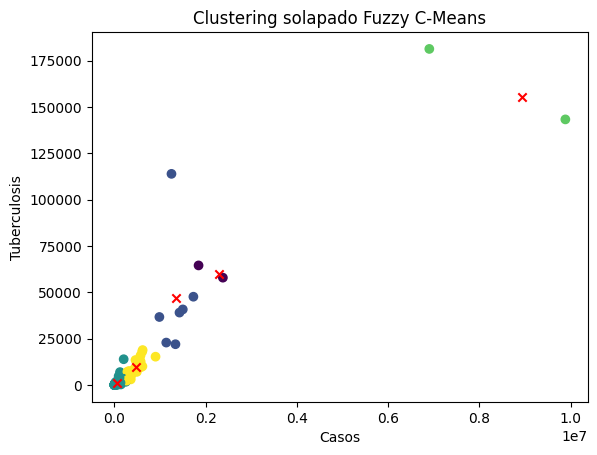

In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz

# Obtener los datos para el clustering
data = df3[['cases', 'deaths', 'pulmonaryConfirmado']].values

# Definir los parámetros del algoritmo FCM
n_clusters = 5
m = 2  # Parámetro de exponente de pertenencia (usualmente se usa 2 para FCM)
error = 0.005  # Criterio de convergencia del algoritmo
maxiter = 150  # Número máximo de iteraciones

# Aplicar Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, m, error=error, maxiter=maxiter, init=None)

# Obtener los clusters asignados para cada punto de datos
clusters = np.argmax(u, axis=0)

# Agregar los clusters al DataFrame original
df3['cluster'] = clusters

# Mostrar los resultados
cluster_counts = df3.groupby(['cluster', 'country']).size().unstack(fill_value=0)
print(cluster_counts)

# Visualización de los resultados (requiere matplotlib)
import matplotlib.pyplot as plt

plt.scatter(df3['cases'], df3['deaths'], c=clusters, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', c='r')
plt.xlabel('Casos')
plt.ylabel('Tuberculosis')
plt.title('Clustering solapado Fuzzy C-Means')
plt.show()


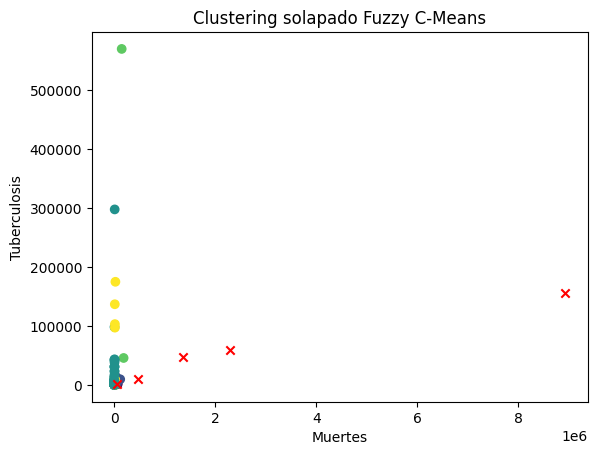

In [ ]:

#plt.scatter(df3['cases'], df3['deaths'], c=clusters, cmap='viridis')
plt.scatter(df3['deaths'], df3['pulmonaryConfirmado'], c=clusters, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', c='r')
plt.xlabel('Muertes')
plt.ylabel('Tuberculosis')
plt.title('Clustering solapado Fuzzy C-Means')
plt.show()


# **Regresion Lineal**
Realizo la transformación a los datos RobustScaler
Esta transformación es robusta a los valores atípicos

In [ ]:
import numpy as np
import pandas as pd

# Data Visualización
import matplotlib.pyplot as plt
import seaborn as sns

data_lm = df_starup[df_starup['year'] == 2020][['pulmonaryConfirmado', 'deaths' ]]
data_lm.head()

,pulmonaryConfirmado,deaths
1,22888,1971.0
4,134,1003.0
7,4114,2596.0
10,1,79.0
13,31268,371.0


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data_normalized = scaler.fit_transform(data_lm)
data_f = pd.DataFrame(data_normalized)
data_f = data_f.round(2)
print(data_f)

        0     1
0    3.47  0.88
1   -0.19  0.41
2    0.45  1.19
3   -0.21 -0.04
4    4.81  0.10
..    ...   ...
186  0.73 -0.08
187  8.52 -0.08
188  0.17  0.22
189  2.52  0.10
190  1.09  0.07

[191 rows x 2 columns]


In [ ]:
data0 = data_f[[0,1]]
data0.reset_index(drop=True, inplace=True)
data0.head(200)
data0.rename(columns={0: 'pulmonary', 1: 'deaths'}, inplace=True)
data0.tail()

,pulmonary,deaths
186,0.73,-0.08
187,8.52,-0.08
188,0.17,0.22
189,2.52,0.10
190,1.09,0.07


In [ ]:
import warnings
from sklearn.cluster import KMeans
xn_clusters = 5

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data0)
data0['cluster'] = kmeans.labels_
data0.tail()

,pulmonary,deaths,cluster
186,0.73,-0.08,0
187,8.52,-0.08,0
188,0.17,0.22,0
189,2.52,0.10,0
190,1.09,0.07,0


In [ ]:
print(data0['cluster'].unique())

[0 3 4 1 2]


Text(0, 0.5, 'Deaths')

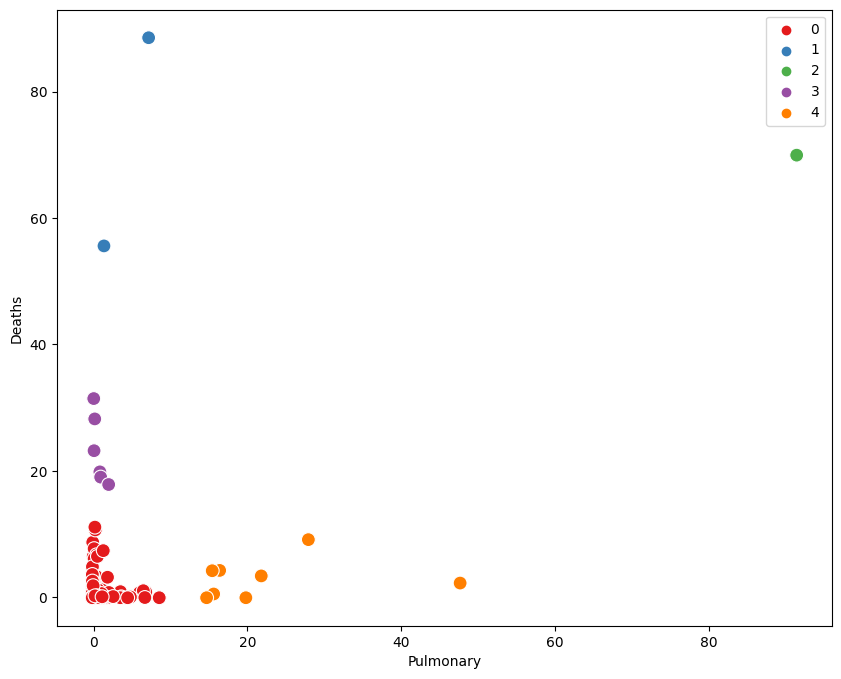

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="pulmonary",
                y="deaths",
                s=100,
                hue=kmeans.labels_,
                data=data0,
               palette="Set1")
plt.xlabel("Pulmonary")
plt.ylabel("Deaths")


In [ ]:
data_lm2 = data0.loc[data0['cluster'] == 4]
data_lm2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 13 to 158
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pulmonary  8 non-null      float64
 1   deaths     8 non-null      float64
 2   cluster    8 non-null      int32  
dtypes: float64(2), int32(1)
memory usage: 224.0 bytes


In [ ]:
x = data_lm2['pulmonary']
y = data_lm2['deaths']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state = 100)

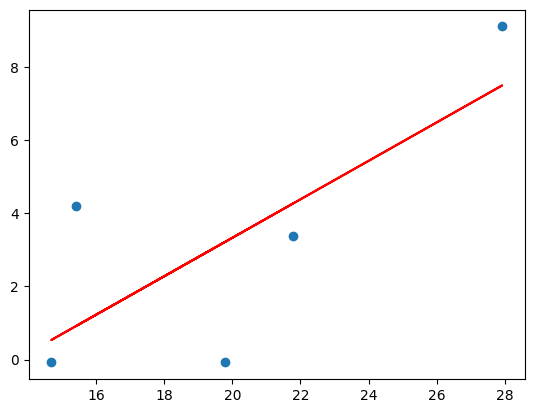

In [ ]:
plt.scatter(x_train, y_train)
plt.plot(x_train, -7.19 + 0.526*x_train, 'r')
plt.show()

In [ ]:
import statsmodels.api as sm
# Add a constant to get an intercept
x_train_sm = sm.add_constant(x_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y_train, x_train_sm).fit()

In [ ]:
lr.params

const       -7.191067
pulmonary    0.526813
dtype: float64

In [ ]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     3.780
Date:                Thu, 15 Jun 2023   Prob (F-statistic):              0.147
Time:                        20:28:56   Log-Likelihood:                -11.158
No. Observations:                   5   AIC:                             26.32
Df Residuals:                       3   BIC:                             25.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.1911      5.552     -1.295      0.2

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## REFERENCIAS

* df1 tomado de: https://data.europa.eu/euodp/es/data/dataset/covid-19-coronavirus-data
* df2 tomado de: https://apps.who.int/gho/data/view.main.57080WBIG?lang=en
